In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import pareto 
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## NYPD data analysis

Instructor: Dr.Stanislav Sobolevsky

Data dictionary: https://data.cityofnewyork.us/api/views/qgea-i56i/files/b21ec89f-4d7b-494e-b2e9-f69ae7f4c228?download=true&filename=NYPD_Complaint_Incident_Level_Data_Footnotes.pdf

### Data Acquisition

In [ ]:
dat = pd.read_csv('/home/jovyan/shared/Data/NYPD_data.csv')
dat.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,394506329,12/31/2019,17:30:00,NaN,NaN,32.0,12/31/2019,118.0,DANGEROUS WEAPONS,793.0,...,NaN,NaN,40.820927,-73.943324,"(40.82092679700002, -73.94332421899996)",PATROL BORO MAN NORTH,NaN,UNKNOWN,UNKNOWN,E
1,968873685,12/29/2019,16:31:00,12/29/2019,16:54:00,47.0,12/29/2019,113.0,FORGERY,729.0,...,NaN,NaN,40.885701,-73.861640,"(40.885701406000074, -73.86164032499995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
2,509837549,12/15/2019,18:45:00,NaN,NaN,109.0,12/29/2019,578.0,HARRASSMENT 2,638.0,...,M,NaN,40.742281,-73.819824,"(40.74228115600005, -73.81982408)",PATROL BORO QUEENS NORTH,NaN,25-44,WHITE HISPANIC,F
3,352454313,12/28/2019,01:00:00,NaN,NaN,47.0,12/28/2019,126.0,MISCELLANEOUS PENAL LAW,117.0,...,M,NaN,40.875311,-73.847545,"(40.87531145100007, -73.84754521099995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
4,248803469,09/05/2008,21:41:00,NaN,NaN,NaN,09/05/2008,101.0,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,NaN,40.698827,-73.938819,"(40.698827283, -73.938819047)",NaN,NaN,25-44,BLACK,M


In [ ]:
dat.shape

(653075, 35)

In [ ]:
dat.OFNS_DESC.unique()

array(['DANGEROUS WEAPONS', 'FORGERY', 'HARRASSMENT 2',
       'MISCELLANEOUS PENAL LAW', 'MURDER & NON-NEGL. MANSLAUGHTER',
       'BURGLARY', 'DANGEROUS DRUGS', 'PETIT LARCENY',
       'OFF. AGNST PUB ORD SENSBLTY &', 'GRAND LARCENY', 'FELONY ASSAULT',
       'ASSAULT 3 & RELATED OFFENSES', 'ARSON', 'RAPE', 'SEX CRIMES',
       'GRAND LARCENY OF MOTOR VEHICLE', 'ROBBERY',
       'CRIMINAL MISCHIEF & RELATED OF', 'THEFT-FRAUD',
       'VEHICLE AND TRAFFIC LAWS', 'CRIMINAL TRESPASS',
       'OFFENSES INVOLVING FRAUD', 'FRAUDS',
       'OFFENSES AGAINST PUBLIC ADMINI', 'OFFENSES AGAINST THE PERSON',
       'ADMINISTRATIVE CODE', 'INTOXICATED & IMPAIRED DRIVING',
       'ESCAPE 3', 'NYS LAWS-UNCLASSIFIED FELONY',
       'POSSESSION OF STOLEN PROPERTY', 'THEFT OF SERVICES',
       'KIDNAPPING & RELATED OFFENSES', 'OTHER OFFENSES RELATED TO THEF',
       'UNAUTHORIZED USE OF A VEHICLE', "BURGLAR'S TOOLS",
       'ENDAN WELFARE INCOMP', 'FRAUDULENT ACCOSTING',
       'AGRICULTURE & MRKTS LA

In [ ]:
len(dat[dat['OFNS_DESC']=='MURDER & NON-NEGL. MANSLAUGHTER'])

975

In [ ]:
dat.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

## Data cleaning 

### 1. filter out missing/wrong date and times, missing borough name and duplicate complaints from the data

In [ ]:
# code here 
#remove unnecessary columns to save memory
data = dat[['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'OFNS_DESC', 'BORO_NM', 'PARKS_NM', 'Latitude', 'Longitude']]

# make sure to convert date column to datetime
data['crime_date'] = pd.to_datetime(data['CMPLNT_FR_DT'], errors = 'coerce')

#drop missing date and time
data = data.loc[data['crime_date'].notna()]
data = data.loc[data['CMPLNT_FR_TM'].notna()]

#drop unreasonable time
data = data.loc[(data['CMPLNT_FR_TM']<= '23:59:59') & (data['CMPLNT_FR_TM']>= '00:00:00')]

#drop missing borough names
data = data.loc[data['BORO_NM'].notna()]

#drop duplicate complaint number
data = data.drop_duplicates('CMPLNT_NUM')

data.shape

(651981, 9)

### 2. Remove rows where location is parks or greenspace and keep data for 2019 and after

In [ ]:
# parks name is in 'PARKS_NM' column. If a crime has occured outside a parkspace, this value would be NaN
data = data.loc[data['PARKS_NM'].isna()]
data.shape

(646839, 9)

In [ ]:
## check the timeline of data
data['crime_date'].describe()

count                  646839
unique                   4437
top       2019-01-01 00:00:00
freq                     1991
first     1911-12-20 00:00:00
last      2020-11-20 00:00:00
Name: crime_date, dtype: object

In [ ]:
# remove data <2019
#this task only asked to remove "data before 2019"
#will remove data that was after 2019 in a later section
data = data.loc[(data['crime_date']>= '2019-01-01')]
data.shape

(446834, 9)

### 3. keep type 1 crimes as defined by FBI from the data : 
https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/offense-definitions

In [ ]:
data = data.loc[(data['OFNS_DESC'] == 'ARSON') | (data['OFNS_DESC'] == 'BURGLARY')
               | (data['OFNS_DESC'] == 'FELONY ASSAULT') | (data['OFNS_DESC'] == 'GRAND LARCENY')
               | (data['OFNS_DESC'] == 'GRAND LARCENY OF MOTOR VEHICLE') | (data['OFNS_DESC'] == 'MURDER & NON-NEGL. MANSLAUGHTER')
               | (data['OFNS_DESC'] == 'RAPE') | (data['OFNS_DESC'] == 'ROBBERY')]
data.shape

(91527, 9)

In [ ]:
from collections import Counter
crime_count = data['OFNS_DESC'].str.replace(r'[ -]', '_', regex=True).values
Counter(crime_count)

Counter({'BURGLARY': 10609,
         'GRAND_LARCENY': 40437,
         'FELONY_ASSAULT': 20248,
         'ARSON': 676,
         'RAPE': 1297,
         'GRAND_LARCENY_OF_MOTOR_VEHICLE': 5347,
         'ROBBERY': 12913})

As seen from the cell above, although "MURDER & NON-NEGL. MANSLAUGHTER" was selected, there was no entry that actually fits this category after the previous filtering steps

### 4. keep rows with location within NYC

https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data?no_mobile=true .

Spatial joint to keep only rows within NYC

In [ ]:
# remove rows with location outside NYC
#check longitude
data = data.loc[(data['Longitude'] >= -74.257159) & (data['Longitude'] <= -73.699215) & 
            (data['Longitude'] >= -74.257159) & (data['Longitude'] <= -73.699215)]
#check latitude
data = data.loc[(data['Latitude'] >= 40.495992) & (data['Latitude'] <= 40.915568) & 
            (data['Latitude'] >= 40.495992) & (data['Latitude'] <= 40.915568)]
data.shape

(91527, 9)

From the filtering step above, it seems like all data entries are alredy within the boundary of New York City

In [ ]:
## zip codes map
# zips = gpd.read_file('Data/ZIPCODE/ZIP_CODE_040114.shp')
zips = gpd.read_file('/home/jovyan/shared/Data/ZIP_CODE/ZIP_CODE_040114.shp')
zips = zips.to_crs(epsg=4326)
zips.shape

(263, 13)

In [ ]:
zips['COUNTY'].replace({'New York': 'MANHATTAN', 'Bronx':'BRONX', 'Kings':'BROOKLYN', 'Queens':'QUEENS', 'Richmond':'STATEN ISLAND'}, inplace=True)

Note: 'ZIPCODE' column has unique codes. The borough name is given in 'COUNTY' column. The counties and boroughs are synonymous in NYC. 'New York' county corresponds to Manhattan, 'Kings' to Brooklyn, 'Richmond' to Staten Island

In [ ]:
#zips.COUNTY.unique()

In [ ]:
#zips.plot(figsize=(8,8))

In [ ]:
gdata = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdata.shape

(91527, 10)

In [ ]:
data_merge = gpd.sjoin(gdata, zips, how='left', op='within')
data_merge['incident'] = 1
data_merge

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,OFNS_DESC,BORO_NM,PARKS_NM,Latitude,Longitude,crime_date,geometry,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,incident
5,293718737,12/27/2019,22:00:00,BURGLARY,MANHATTAN,NaN,40.720759,-73.980466,2019-12-27,POINT (-73.98047 40.72076),...,61455.0,1.590352e+07,NY,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,1
10,585574881,12/24/2019,16:00:00,GRAND LARCENY,MANHATTAN,NaN,40.750431,-73.989282,2019-12-24,POINT (-73.98928 40.75043),...,22413.0,1.779494e+07,NY,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,1
14,249276017,12/20/2019,14:00:00,FELONY ASSAULT,BRONX,NaN,40.822271,-73.911698,2019-12-20,POINT (-73.91170 40.82227),...,44140.0,2.894411e+07,NY,BRONX,36,005,http://www.usps.com/,0.0,0.0,1
16,183266811,12/20/2019,01:35:00,BURGLARY,BROOKLYN,NaN,40.632545,-73.981951,2019-12-20,POINT (-73.98195 40.63254),...,77354.0,4.355518e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,1
18,431547413,12/10/2019,20:06:00,ARSON,MANHATTAN,NaN,40.711952,-73.989855,2019-12-10,POINT (-73.98985 40.71195),...,81305.0,2.628013e+07,NY,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462045,864698738,01/05/2019,21:18:00,FELONY ASSAULT,BRONX,NaN,40.825012,-73.914133,2019-01-05,POINT (-73.91413 40.82501),...,44140.0,2.894411e+07,NY,BRONX,36,005,http://www.usps.com/,0.0,0.0,1
462056,334524240,01/04/2019,18:19:00,GRAND LARCENY,STATEN ISLAND,NaN,40.560329,-74.163770,2019-01-04,POINT (-74.16377 40.56033),...,27612.0,6.275104e+07,NY,STATEN ISLAND,36,085,http://www.usps.com/,0.0,0.0,1
462061,181896226,01/03/2019,21:35:00,ROBBERY,BROOKLYN,NaN,40.687653,-73.916852,2019-01-03,POINT (-73.91685 40.68765),...,80232.0,3.858048e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,1
462063,377133908,01/01/2019,04:00:00,GRAND LARCENY,BROOKLYN,NaN,40.720082,-73.962790,2019-01-01,POINT (-73.96279 40.72008),...,28481.0,1.777221e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,1


In [ ]:
#drop the duplicated lines for cmplnt_num; they might have appeared after the merge step
data_merge = data_merge.drop_duplicates('CMPLNT_NUM')
data_merge.shape

(91527, 24)

In [ ]:
task_1_4 = data_merge.groupby(['ZIPCODE'], as_index=False).agg({'incident':'sum'})
task_1_4.shape

(190, 2)

In [ ]:
#create a dataframe joint at zipcode level
task_1 = zips.merge(task_1_4,left_on='ZIPCODE',right_on='ZIPCODE',how='left')
task_1

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,incident
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",160.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679...",796.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668...",1233.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670...",556.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650...",336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,STATEN ISLAND,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.12065 40.64104, -74.12057 40.641...",165.0
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.84076 40.62536, -73.84306 40.627...",150.0
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95805 40.72442, -73.95772 40.724...",372.0
261,10162,1,New York,0.0,2.103489e+04,NY,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95133 40.76931, -73.95165 40.769...",NaN


## Exploratory Analysis

### 1. time series plotting

In [ ]:
# group total crimes by daily numbers
crime_day = data_merge.groupby(['crime_date'], as_index=False).agg({'CMPLNT_NUM':'count'})
crime_day.shape

(404, 2)

Text(0.5, 0, 'date')

<Figure size 1080x432 with 0 Axes>

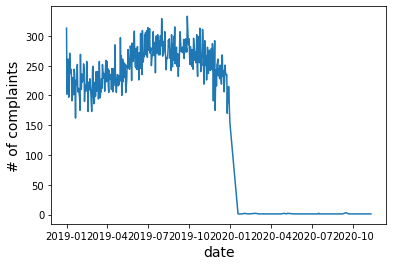

In [ ]:
# plot as a time series
plt.figure(figsize=(15, 6))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(crime_day.crime_date, crime_day.CMPLNT_NUM)

ax.set_ylabel('# of complaints', fontsize=14)
ax.set_xlabel('date', fontsize=14)

### 2. plotting on borough and zip code level normalized by population

In [ ]:
#calculate population per borough
#cannot aggregate population sum in the merged file, since each entry recorded the total population
#of each corresponding zip code area... and many points had the same zipcode
pop_borough = zips.groupby(['COUNTY'], as_index=False).agg({'POPULATION':'sum'})
pop_borough

,COUNTY,POPULATION
0,BRONX,1431301.0
1,BROOKLYN,2548896.0
2,MANHATTAN,1687421.0
3,QUEENS,2262768.0
4,STATEN ISLAND,468220.0


In [ ]:
# group crime numbers by borough and normalize by their population (per 100,000). Population is given in the zips shapefile
#population calculated in the cell above
crime_borough = data_merge.groupby(['BORO_NM'], as_index=False).agg({'CMPLNT_NUM':'count'})
crime_borough['crime_rate'] = (crime_borough['CMPLNT_NUM'] / pop_borough['POPULATION'])*100000
crime_borough

,BORO_NM,CMPLNT_NUM,crime_rate
0,BRONX,18919,1321.804428
1,BROOKLYN,26290,1031.426939
2,MANHATTAN,25864,1532.753237
3,QUEENS,18145,801.893963
4,STATEN ISLAND,2309,493.144248


Text(0.5, 0, 'Borough')

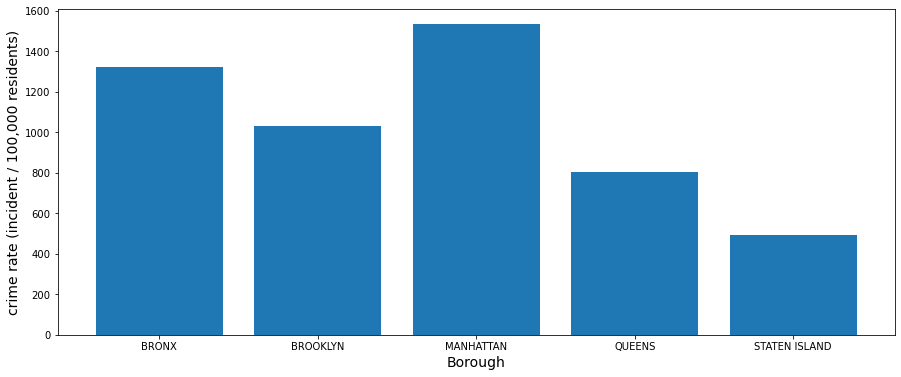

In [ ]:
# plot as a bar plot
plt.figure(figsize=(15, 6))
plt.bar(crime_borough.BORO_NM, crime_borough.crime_rate)

plt.ylabel('crime rate (incident / 100,000 residents)', fontsize=14)
plt.xlabel('Borough', fontsize=14)

In [ ]:
# now group by zip codes, normalize by their population
import copy
crime_zip = copy.deepcopy(task_1)
crime_zip['crime_r'] = (crime_zip['incident'] / crime_zip['POPULATION'])*100000 

#remove infinite and nan rows
crime_zip['crime_r'].replace([np.inf, -np.inf], np.nan, inplace=True)
crime_zip = crime_zip.loc[crime_zip['crime_r'].notna()]

crime_zip.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,incident,crime_r
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",160.0,856.485199
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93740 40.67973, -73.93487 40.679...",796.0,1275.109730
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.90294 40.67084, -73.90223 40.668...",1233.0,1470.202466
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.95797 40.67066, -73.95576 40.670...",556.0,983.600757
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.97208 40.65060, -73.97192 40.650...",336.0,464.858882


<AxesSubplot:>

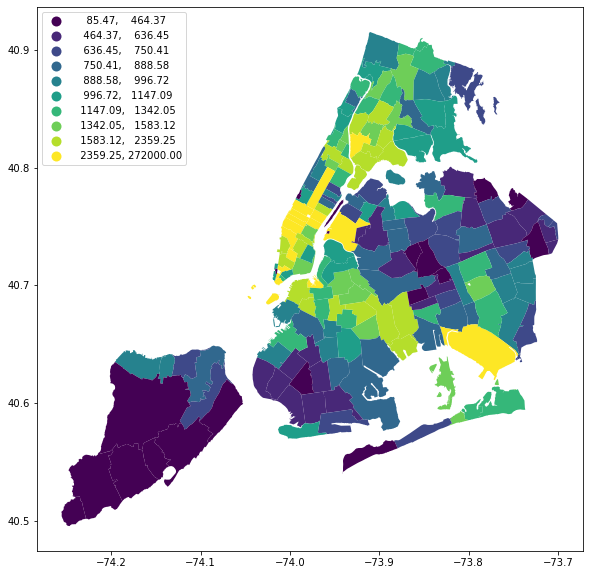

In [ ]:
# plot as a heatmap with quantiles color scheme
fig, ax = plt.subplots(1, figsize=(10,10))

crime_zip.plot(ax=ax, column='crime_r', scheme='Quantiles', k=10, legend=True, 
              legend_kwds={'loc': 'upper left'})

### 3. bar plot of total crimes vs a) months b) day of week and c) hour of day

In [ ]:
# code here
task_2_3 = copy.deepcopy(data_merge)
task_2_3['crime_month'] = task_2_3['crime_date'].dt.month
task_2_3['crime_dow'] = task_2_3['crime_date'].dt.dayofweek
task_2_3['crime_hour'] = pd.to_datetime(task_2_3['CMPLNT_FR_TM'], format='%H:%M:%S').dt.hour
task_2_3

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,OFNS_DESC,BORO_NM,PARKS_NM,Latitude,Longitude,crime_date,geometry,...,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,incident,crime_month,crime_dow,crime_hour
5,293718737,12/27/2019,22:00:00,BURGLARY,MANHATTAN,NaN,40.720759,-73.980466,2019-12-27,POINT (-73.98047 40.72076),...,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,1,12,4,22
10,585574881,12/24/2019,16:00:00,GRAND LARCENY,MANHATTAN,NaN,40.750431,-73.989282,2019-12-24,POINT (-73.98928 40.75043),...,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,1,12,1,16
14,249276017,12/20/2019,14:00:00,FELONY ASSAULT,BRONX,NaN,40.822271,-73.911698,2019-12-20,POINT (-73.91170 40.82227),...,BRONX,36,005,http://www.usps.com/,0.0,0.0,1,12,4,14
16,183266811,12/20/2019,01:35:00,BURGLARY,BROOKLYN,NaN,40.632545,-73.981951,2019-12-20,POINT (-73.98195 40.63254),...,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,1,12,4,1
18,431547413,12/10/2019,20:06:00,ARSON,MANHATTAN,NaN,40.711952,-73.989855,2019-12-10,POINT (-73.98985 40.71195),...,MANHATTAN,36,061,http://www.usps.com/,0.0,0.0,1,12,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462045,864698738,01/05/2019,21:18:00,FELONY ASSAULT,BRONX,NaN,40.825012,-73.914133,2019-01-05,POINT (-73.91413 40.82501),...,BRONX,36,005,http://www.usps.com/,0.0,0.0,1,1,5,21
462056,334524240,01/04/2019,18:19:00,GRAND LARCENY,STATEN ISLAND,NaN,40.560329,-74.163770,2019-01-04,POINT (-74.16377 40.56033),...,STATEN ISLAND,36,085,http://www.usps.com/,0.0,0.0,1,1,4,18
462061,181896226,01/03/2019,21:35:00,ROBBERY,BROOKLYN,NaN,40.687653,-73.916852,2019-01-03,POINT (-73.91685 40.68765),...,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,1,1,3,21
462063,377133908,01/01/2019,04:00:00,GRAND LARCENY,BROOKLYN,NaN,40.720082,-73.962790,2019-01-01,POINT (-73.96279 40.72008),...,BROOKLYN,36,047,http://www.usps.com/,0.0,0.0,1,1,1,4


Text(0.5, 0, 'month')

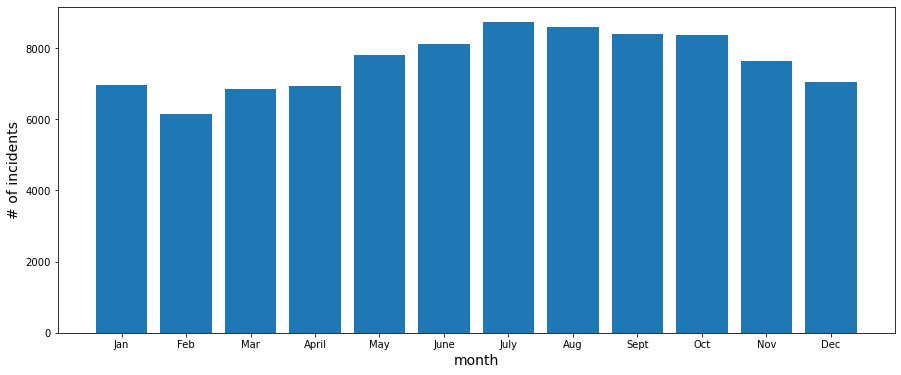

In [ ]:
#group by month
crime_by_month = task_2_3.groupby(['crime_month'], as_index=False).agg({'CMPLNT_NUM':'count'})

plt.figure(figsize=(15, 6))
plt.bar(crime_by_month.crime_month, crime_by_month.CMPLNT_NUM)
pos = crime_by_month['crime_month'].values
ti = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(pos, ti)
plt.ylabel('# of incidents', fontsize=14)
plt.xlabel('month', fontsize=14)

In [ ]:
#print values for sanity check
crime_by_month

,crime_month,CMPLNT_NUM
0,1,6962
1,2,6141
2,3,6857
3,4,6926
4,5,7806
5,6,8097
6,7,8724
7,8,8591
8,9,8383
9,10,8375


Text(0.5, 0, 'dow')

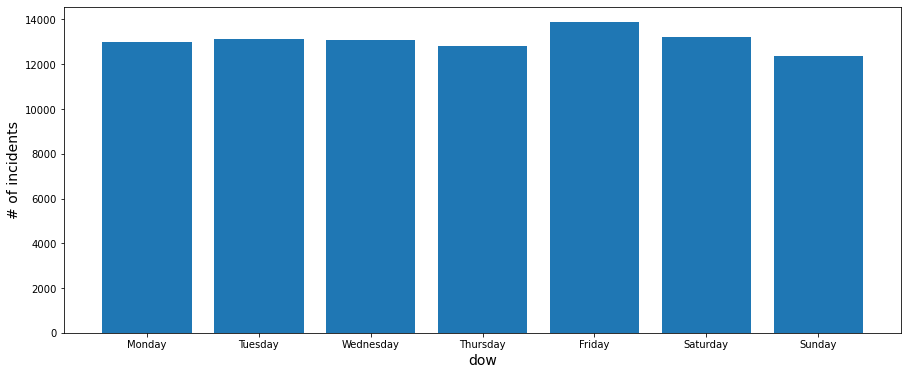

In [ ]:
#group by day
crime_by_day = task_2_3.groupby(['crime_dow'], as_index=False).agg({'CMPLNT_NUM':'count'})

plt.figure(figsize=(15, 6))
plt.bar(crime_by_day.crime_dow, crime_by_day.CMPLNT_NUM)
pos = crime_by_day['crime_dow'].values
ti = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(pos, ti)
plt.ylabel('# of incidents', fontsize=14)
plt.xlabel('dow', fontsize=14)

In [ ]:
#print values for sanity check
crime_by_day

,crime_dow,CMPLNT_NUM
0,0,12975
1,1,13144
2,2,13099
3,3,12828
4,4,13880
5,5,13232
6,6,12369


Text(0.5, 0, 'hour of day')

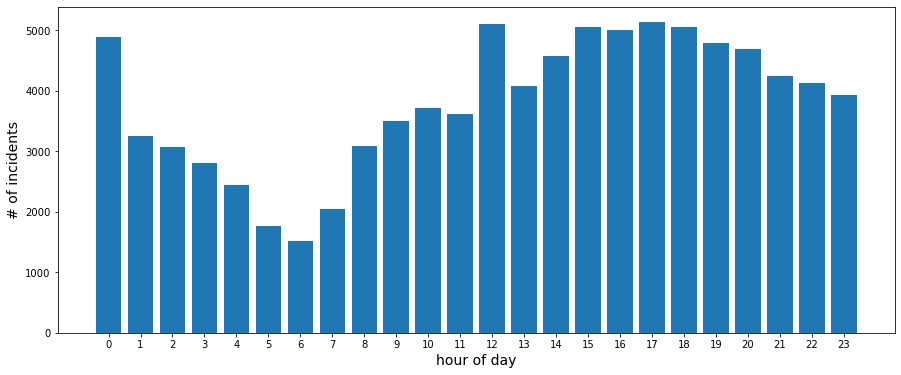

In [ ]:
#group by hour
crime_by_hour = task_2_3.groupby(['crime_hour'], as_index=False).agg({'CMPLNT_NUM':'count'})

plt.figure(figsize=(15, 6))
plt.bar(crime_by_hour.crime_hour, crime_by_hour.CMPLNT_NUM)

plt.xticks(crime_by_hour.crime_hour)
plt.ylabel('# of incidents', fontsize=14)
plt.xlabel('hour of day', fontsize=14)

In [ ]:
#print values for sanity check
crime_by_hour

,crime_hour,CMPLNT_NUM
0,0,4886
1,1,3257
2,2,3065
3,3,2810
4,4,2441
5,5,1768
6,6,1518
7,7,2054
8,8,3085
9,9,3495


### 4. Felony assault vs grand larceny by a) day of week b) hour of day

In [ ]:
# filter data for above crime types
task_2_4 = task_2_3.loc[(task_2_3['OFNS_DESC'] == 'FELONY ASSAULT') | (task_2_3['OFNS_DESC'] == 'GRAND LARCENY')]
task_2_4.shape

(60685, 27)

In [ ]:
# group the numbers and normalize by total city population (per 100,000)
#recall that total city population is a fixed number, 
#that means, dividing complaint number by total population wouldn't have affected the shape of the output
#just the scale
pop = pop_borough['POPULATION'].sum()
crime_by_type = task_2_4.groupby(['OFNS_DESC'], as_index=False).agg({'CMPLNT_NUM':'count'})
crime_by_type['rate'] = (crime_by_type['CMPLNT_NUM'] / pop)*100000
crime_by_type

,OFNS_DESC,CMPLNT_NUM,rate
0,FELONY ASSAULT,20248,241.087628
1,GRAND LARCENY,40437,481.472759


In [ ]:
#felony assault by dow
fa_dow = task_2_4.loc[task_2_4['OFNS_DESC'] == 'FELONY ASSAULT'].groupby(['crime_dow'], as_index=False).agg({'CMPLNT_NUM':'count'})
fa_dow['rate'] = (fa_dow['CMPLNT_NUM'] / pop)*100000

#grand larceny by dow
gl_dow = task_2_4.loc[task_2_4['OFNS_DESC'] == 'GRAND LARCENY'].groupby(['crime_dow'], as_index=False).agg({'CMPLNT_NUM':'count'})
gl_dow['rate'] = (gl_dow['CMPLNT_NUM'] / pop)*100000

#felont assault by hour
fa_hour = task_2_4.loc[task_2_4['OFNS_DESC'] == 'FELONY ASSAULT'].groupby(['crime_hour'], as_index=False).agg({'CMPLNT_NUM':'count'})
fa_hour['rate'] = (fa_hour['CMPLNT_NUM'] / pop)*100000

#grand larceny by hour
gl_hour = task_2_4.loc[task_2_4['OFNS_DESC'] == 'GRAND LARCENY'].groupby(['crime_hour'], as_index=False).agg({'CMPLNT_NUM':'count'})
gl_hour['rate'] = (gl_hour['CMPLNT_NUM'] / pop)*100000

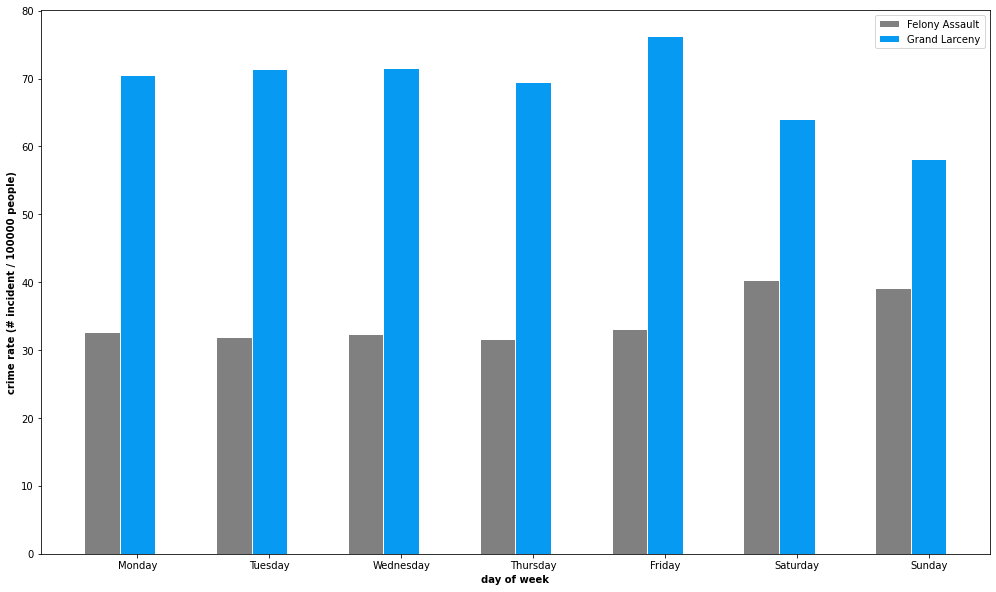

In [ ]:
#by day of week
plt.figure(figsize=(17, 10))
# set width of bars
barWidth = 0.27
 
# set heights of bars
bars1 = fa_dow['rate']
bars2 = gl_dow['rate']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#808080', width=barWidth, edgecolor='white', label='Felony Assault')
plt.bar(r2, bars2, color='#069af3', width=barWidth, edgecolor='white', label='Grand Larceny')

 
# Add xticks on the middle of the group bars
plt.xlabel('day of week', fontweight='bold')
plt.ylabel('crime rate (# incident / 100000 people)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
#sanity check
fa_dow

,crime_dow,CMPLNT_NUM,rate
0,0,2740,32.624462
1,1,2683,31.945778
2,2,2714,32.314887
3,3,2655,31.612389
4,4,2787,33.184078
5,5,3384,40.292401
6,6,3285,39.113634


In [ ]:
#sanity check
gl_dow

,crime_dow,CMPLNT_NUM,rate
0,0,5922,70.511702
1,1,5997,71.404707
2,2,6009,71.547588
3,3,5833,69.452002
4,4,6405,76.262656
5,5,5385,64.117783
6,6,4886,58.176321


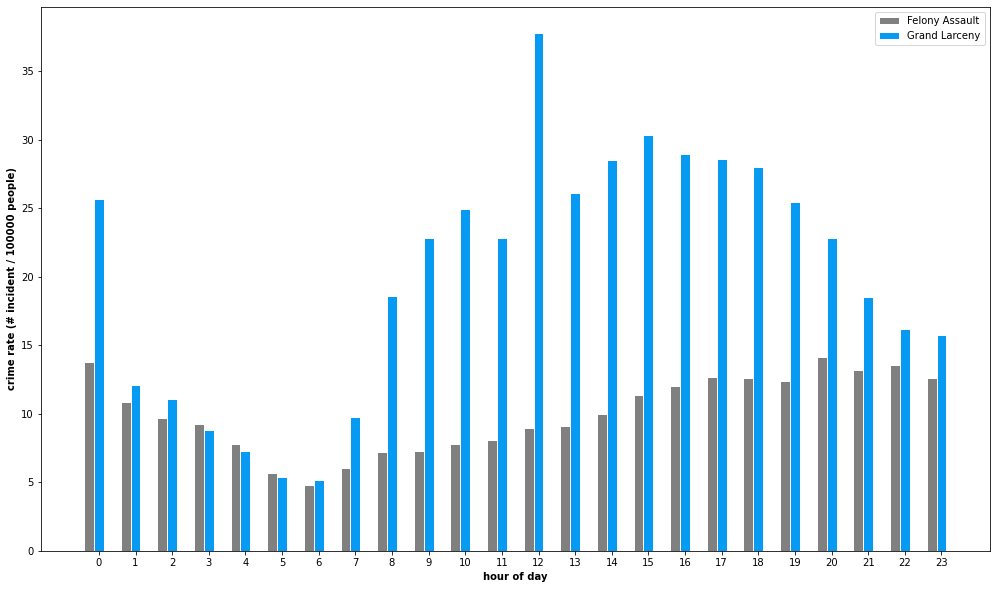

In [ ]:
plt.figure(figsize=(17, 10))
# set width of bars
barWidth = 0.27
 
# set heights of bars
bars1 = fa_hour['rate']
bars2 = gl_hour['rate']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#808080', width=barWidth, edgecolor='white', label='Felony Assault')
plt.bar(r2, bars2, color='#069af3', width=barWidth, edgecolor='white', label='Grand Larceny')

 
# Add xticks on the middle of the group bars
plt.xlabel('hour of day', fontweight='bold')
plt.ylabel('crime rate (# incident / 100000 people)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], 
           ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18',
           '19','20','21','22','23'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
#sanity check
fa_hour

,crime_hour,CMPLNT_NUM,rate
0,0,1155,13.752282
1,1,915,10.894665
2,2,813,9.680178
3,3,779,9.275349
4,4,654,7.787007
5,5,475,5.655700
6,6,406,4.834136
7,7,509,6.060530
8,8,608,7.239297
9,9,614,7.310737


In [ ]:
#sanity check
gl_hour

,crime_hour,CMPLNT_NUM,rate
0,0,2155,25.659020
1,1,1015,12.085339
2,2,929,11.061359
3,3,739,8.799079
4,4,611,7.275017
5,5,450,5.358032
6,6,434,5.167524
7,7,819,9.751618
8,8,1565,18.634045
9,9,1918,22.837123


### % distribution of crime types by borough in pie charts 

for matplotlib pie charts documentation: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html

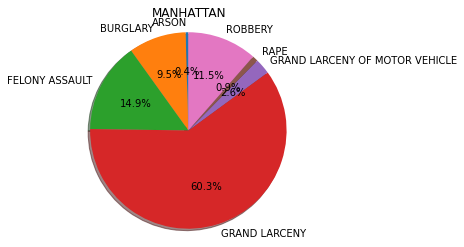

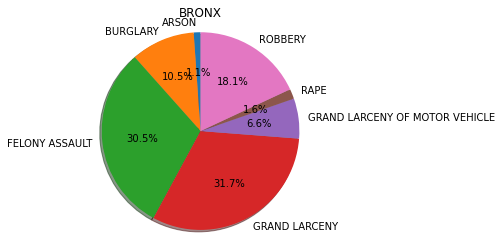

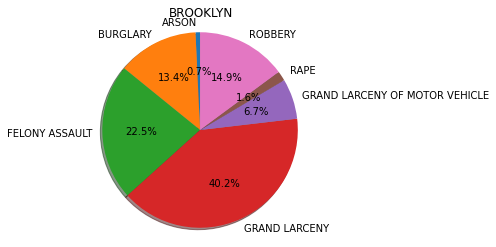

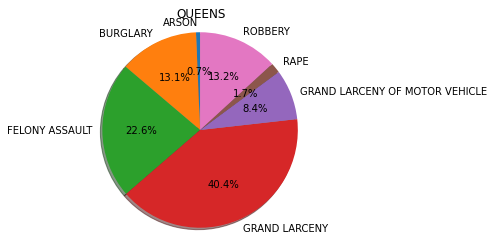

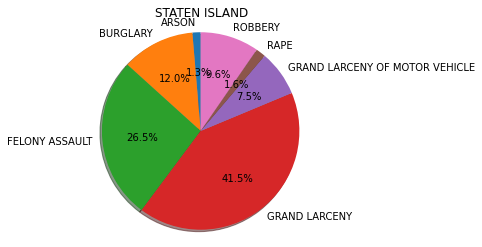

In [ ]:
# plot 5 pie charts for each borough depicting % of each crime type within type 1 crimes

for boro in data.BORO_NM.unique():
    # complete this code here
    #create a dataframe for each borough
    df1 = data.loc[data['BORO_NM']==boro]
    #group by crime type for each borough's dataframe
    df_g = df1.groupby(['OFNS_DESC'], as_index=False).agg({'CMPLNT_NUM':'count'})

    #plot    
    labels = df_g['OFNS_DESC']
    sizes = df_g['CMPLNT_NUM']
    fig1, ax1 = plt.subplots()
    ax1.set_title(boro)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Hypothesis testing tasks


### 1. plotting distributions and normality test

In [ ]:
def distribution_analysis(x, log_scale = False, fit_distribution = 'None', bins = 50, vis_means = True, vis_curve = True, print_outputs = True):

    if log_scale: 
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale 
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.15f}({:.15f}), mean = {:.15f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.15f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation 
    print('Standard deviation = {:.15f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.15f}'.format(p,np.percentile(x,p)))
        
    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve, 
        bins=bins,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})
    
    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)
        
    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)
    
    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters
    
    #fit and visualize the theoretic distribution
    if fit_distribution == 'normal':
        pars = norm.fit(x1)
        plt.plot(h,norm.pdf(h,*pars),'r')
    elif fit_distribution == 'gev':
        pars = gev.fit(x1)
        plt.plot(h,gev.pdf(h,*pars),'r')
    elif fit_distribution == 'pareto':
        pars = pareto.fit(x1)
        plt.plot(h,pareto.pdf(h,*pars),'r')
    
    plt.xlabel(xlabel) #add x label 
    plt.ylim(ylim) #restore the y-range of original distribution density values 
    plt.show()
    return pars

In [ ]:
# group type 1 crime numbers per day for 2019
cd = copy.deepcopy(task_2_3)
c_d = cd.loc[(cd['crime_date'] >= '2019-01-01') & (cd['crime_date'] <= '2019-12-31')]
cd2019 = c_d.groupby(['crime_date'], as_index=False).agg({'CMPLNT_NUM':'count'})
cd2019

,crime_date,CMPLNT_NUM
0,2019-01-01,313
1,2019-01-02,202
2,2019-01-03,259
3,2019-01-04,261
4,2019-01-05,230
...,...,...
360,2019-12-27,188
361,2019-12-28,215
362,2019-12-29,198
363,2019-12-30,172


Mean = 250.632876712328766
Standard deviation = 32.865226181733739
1 percentile = 172.639999999999986
5 percentile = 197.199999999999989
25 percentile = 227.000000000000000
50 percentile = 251.000000000000000
75 percentile = 275.000000000000000
95 percentile = 302.000000000000000
99 percentile = 313.360000000000014


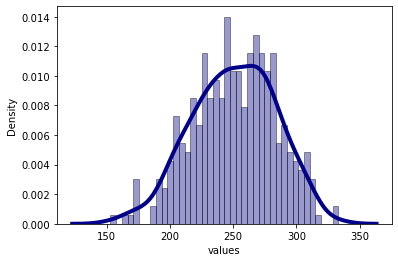

In [ ]:
# plot the distribution (density plot)
distribution_analysis(cd2019.CMPLNT_NUM, bins=40, vis_means = False)

Mean = 250.632876712328766
Standard deviation = 32.865226181733739
1 percentile = 172.639999999999986
5 percentile = 197.199999999999989
25 percentile = 227.000000000000000
50 percentile = 251.000000000000000
75 percentile = 275.000000000000000
95 percentile = 302.000000000000000
99 percentile = 313.360000000000014


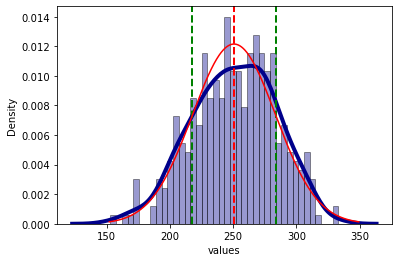

In [ ]:
# normality test aka if follows normal distribution
distribution_analysis(cd2019.CMPLNT_NUM, fit_distribution='normal',bins=40);

In [ ]:
def is_normal(x): 
    return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [ ]:
is_normal(cd2019.CMPLNT_NUM)

KstestResult(statistic=0.04692494296779304, pvalue=0.38570806588523665)

Based on the p-value of 0.3857 (i.e. greater than 0.05), we cannot reject the hypothesis that this dataset follows a normal distribution. As a result, we can treat this dataset as following a normal distritbution

### Weekdays VS Weekend distribution

In [ ]:
# create dataframes for weekdays and weekends
crime_wd = c_d.loc[(c_d['crime_dow'] >= 0) & (c_d['crime_dow'] <= 4)]
crime_wk = c_d.loc[(c_d['crime_dow'] == 5) | (c_d['crime_dow'] == 6)]

In [ ]:
# group daily numbers for weekdays and weekends
g_crime_wd = crime_wd.groupby(['crime_date'], as_index=False).agg({'CMPLNT_NUM':'count'})
g_crime_wk = crime_wk.groupby(['crime_date'], as_index=False).agg({'CMPLNT_NUM':'count'})

#normalize by population; use the "pop" variable that we calculated for the whole city
#did not specify for location, and therefore use whole city's population for this normalization
g_crime_wd['c_rate'] = (g_crime_wd['CMPLNT_NUM'] / pop)*100000
g_crime_wk['c_rate'] = (g_crime_wk['CMPLNT_NUM'] / pop)*100000

#once again, since the population here is a fixed number for the sume of the whole city
#normalizing wouldn't change the shape, just the scale
#and the result for ks or t-tests shouldn't vary

Mean = 3.005789823268819
Standard deviation = 0.398495125525745
1 percentile = 2.038433520991460
5 percentile = 2.369440833395447
25 percentile = 2.738549706939461
50 percentile = 3.012404677633407
75 percentile = 3.298166386183612
95 percentile = 3.595834832590076
99 percentile = 3.743478382007681


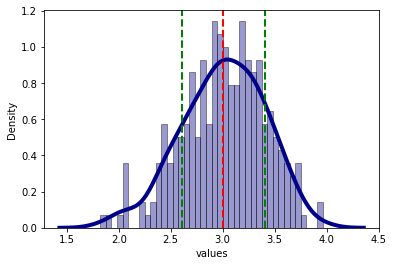

In [ ]:
# plot distribution (density plot)
#weekdays
distribution_analysis(g_crime_wd.c_rate, bins=40)

Mean = 2.930087903415620
Standard deviation = 0.369010453926332
1 percentile = 2.262637394824808
5 percentile = 2.347413368361368
25 percentile = 2.664132595337845
50 percentile = 2.893337299070822
75 percentile = 3.217795905653866
95 percentile = 3.563091303485364
99 percentile = 3.678824795448197


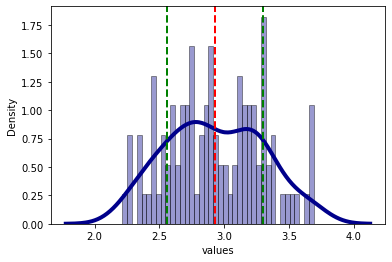

In [ ]:
#weekends
distribution_analysis(g_crime_wk.c_rate, bins=40)

In [ ]:
# t-test
stats.ttest_ind(g_crime_wd['c_rate'],
                g_crime_wk['c_rate'])

Ttest_indResult(statistic=1.6723889005204076, pvalue=0.09530928900409187)

As seen from the t-test, we obtained a p-value of 0.0953, which is slightly less than 0.1 (i.e. 10% significance level as mentioned in the prompt). Therefore, we are rejecting the hypothesis that the crime rate during weekdays and weekends have the same mean.

In [ ]:
# k-s test
stats.ks_2samp(g_crime_wd['c_rate'],
                g_crime_wk['c_rate'])

KstestResult(statistic=0.14968317123489538, pvalue=0.06303387257522763)

As seen from the ks-test, we obtained a p-value of 0.063, which is less than 0.1 (i.e. 10% significance level as mentioned in the prompt). Therefore, we are rejecting the hypothesis that the crime rate during weekdays and weekends have the same distribution.